In [1]:
import geopandas as gpd
import pandas as pd

import mapillary as mly
#import json

import glob


import gzip

from datetime import datetime



In [133]:


## TRAFFFIC SIGNS
# https://www.mapillary.com/developer/api-documentation/traffic-signs?locale=

# Unterschiedliche Verkehrszeichen in Deutschland für Radwege

# https://trafficsigns.osm-verkehrswende.org/DE?signs=DE:237
# Radweg
de_237="regulatory--bicycles-only--g1"

# https://trafficsigns.osm-verkehrswende.org/DE?signs=DE:240
# Gemeinsamer Geh- und Radweg
de_240="regulatory--shared-path-pedestrians-and-bicycles--g1"

# https://trafficsigns.osm-verkehrswende.org/DE?signs=DE:241-30
# Getrennter Rad- und Gehweg
de_241_30="regulatory--dual-path-bicycles-and-pedestrians--g1"

# https://trafficsigns.osm-verkehrswende.org/DE?signs=DE:241-31
# Getrennter Rad- und Gehweg
de_241_31="regulatory--dual-path-pedestrians-and-bicycles--g1"


#_________________

#https://trafficsigns.osm-verkehrswende.org/DE?signs=DE:244.2
# Ende Fahrradstraße
de_244_2=  "regulatory--end-of-bicycles-only--g2"

#_________________

# # https://trafficsigns.osm-verkehrswende.org/DE?signs=DE:1022-10
# # Radfahrer frei
de_1022_10=  "complementary--except-bicycles--g1" 


# # https://trafficsigns.osm-verkehrswende.org/DE?signs=DE:1000-33
# # Radverkehr im Gegenverkehr
de_1000_33=  "complementary--bike-route--g1" 



# Find all parquet files in the tile_cache folder (per state)
parquet_files = glob.glob("../../output/*.parquet")
# Extract and print the dates from the filenames
dates = [f.split("_")[-1].replace(".parquet", "") for f in parquet_files]
# Drop all duplicates in the list
dates = list(set(dates))
print("Dates found in filenames:", dates)
# Read all files and concatenate into one GeoDataFrame
mapillary_trafficsigns = gpd.GeoDataFrame(
    pd.concat([gpd.read_parquet(f) for f in parquet_files], ignore_index=True),
    crs=gpd.read_parquet(parquet_files[0]).crs
)






# Schilder in Germany
mapillary_trafficsigns_cw=mapillary_trafficsigns[mapillary_trafficsigns.value.isin([de_237, de_240, de_241_30, de_241_31, de_244_2, de_1022_10, de_1000_33])]

mapillary_trafficsigns_cw=mapillary_trafficsigns_cw.drop_duplicates(subset=['id'])

mapillary_trafficsigns_cw = mapillary_trafficsigns_cw.drop(columns=["tile_x", "tile_y"])


mapillary_trafficsigns_cw


# value_VZ DE:237
# 

Dates found in filenames: ['2025-10-29']


,geometry,first_seen_at,id,last_seen_at,value
1,POINT (6.69476 53.59648),2022-10-18,766428184457863,2022-10-18,regulatory--shared-path-pedestrians-and-bicycl...
2,POINT (6.68792 53.59318),2017-01-02,290013722802236,2017-01-02,regulatory--shared-path-pedestrians-and-bicycl...
6,POINT (6.69946 53.5974),2022-10-18,644562370527925,2022-10-18,regulatory--shared-path-pedestrians-and-bicycl...
7,POINT (6.69048 53.59314),2017-01-02,189437229692972,2017-01-02,regulatory--shared-path-pedestrians-and-bicycl...
8,POINT (6.68795 53.5932),2017-01-02,289646422838966,2017-01-02,regulatory--bicycles-only--g1
...,...,...,...,...,...
6330494,POINT (7.36988 49.30377),2024-04-14,438831555436126,2024-04-14,complementary--except-bicycles--g1
6330564,POINT (7.3841 49.36201),2016-02-26,966957547455761,2016-02-26,regulatory--shared-path-pedestrians-and-bicycl...
6330573,POINT (7.38416 49.36211),2020-05-20,230815512141642,2020-05-20,regulatory--shared-path-pedestrians-and-bicycl...
6330577,POINT (7.38464 49.36229),2016-02-26,322281759469783,2016-02-26,regulatory--bicycles-only--g1


## Verarbeitung fuer export fuer radinfra.de

In [134]:
### zeitlicher Filter: only signs seen after 2023-01-01


mapillary_trafficsigns_cw=mapillary_trafficsigns_cw[mapillary_trafficsigns_cw["last_seen_at"] > "2023-01-01"].copy()
len(mapillary_trafficsigns_cw)

118473

In [135]:
### räumlicher Filter (Alle Traffic sign an Autobahnen raus, wg vielen falsch-positiven dort)

In [136]:
## parse autobahnen
set_date = "251029" 
motorways=gpd.read_parquet(f"processed_osm_files/processed_motorways_germany_{set_date}.parquet")

## now create a buffer around the traffic signs to check if there is a cycleway nearby
mapillary_trafficsigns_cw_buffered_30 = mapillary_trafficsigns_cw.to_crs(25833).copy()
mapillary_trafficsigns_cw_buffered_30["geometry"] = mapillary_trafficsigns_cw_buffered_30.geometry.buffer(30)
mapillary_trafficsigns_cw_buffered_30 = mapillary_trafficsigns_cw_buffered_30.to_crs(mapillary_trafficsigns_cw.crs)


In [137]:
# helper 
def mark_intersections(buffered_df, target_layer, column_name="has_intersection"):
    """
    Marks which geometries in `buffered_df` intersect with `target_layer`.

    Parameters:
    - buffered_df (GeoDataFrame): The GeoDataFrame containing buffered geometries.
    - target_layer (GeoDataFrame): The GeoDataFrame to check for intersections (e.g., cycleways, motorways).
    - column_name (str): Name of the column to add/overwrite in `buffered_df` indicating intersection (bool).

    Returns:
    - GeoDataFrame: `buffered_df` with a new boolean column `column_name`.
    """
    # Ensure CRS matches
    buffered_df = buffered_df.to_crs(target_layer.crs)

    # Perform spatial join to find intersecting geometries
    joined = gpd.sjoin(buffered_df, target_layer, how="inner", predicate="intersects")

    # Initialize the new column to False
    buffered_df[column_name] = False

    # Set True for geometries that intersect
    matches = joined.index.unique()
    buffered_df.loc[matches, column_name] = True

    return buffered_df


In [138]:
# For motorways (just 30m for both)
mapillary_trafficsigns_cw_buffered_30_mw = mark_intersections(mapillary_trafficsigns_cw_buffered_30, motorways, column_name="has_mw_intersection")

mapillary_trafficsigns_cw_30_mw_false=mapillary_trafficsigns_cw_buffered_30_mw[(mapillary_trafficsigns_cw_buffered_30_mw.has_mw_intersection== False)].copy()

# keep only entries in mapillary_trafficsigns_cw that are present in mapillary_trafficsigns_cw_30_mw_false
mapillary_trafficsigns_cw = mapillary_trafficsigns_cw[mapillary_trafficsigns_cw["id"].isin(mapillary_trafficsigns_cw_30_mw_false["id"])].copy()
len(mapillary_trafficsigns_cw)

117385

In [139]:
# ### calculate days between first_seen_at and last_seen_at
def calc_days_between(row):
    try:
        d1 = datetime.strptime(row['first_seen_at'], "%Y-%m-%d")
        d2 = datetime.strptime(row['last_seen_at'], "%Y-%m-%d")
        return (d2 - d1).days
    except Exception:
        return None

mapillary_trafficsigns_cw["delta_days_seen"] = mapillary_trafficsigns_cw.apply(calc_days_between, axis=1)

In [140]:
mapillary_trafficsigns_cw["Hinweis"] = mapillary_trafficsigns_cw["delta_days_seen"].apply(
    lambda x: "Nur einmalig detektiert, ggf. temporär wie z.B. Baustelle." if x == 0 else ""
)

In [141]:
mapillary_trafficsigns_cw = mapillary_trafficsigns_cw.drop(columns=["delta_days_seen"])


In [142]:
# Mapping dictionary
value_to_ts = {
    'regulatory--dual-path-pedestrians-and-bicycles--g1': "DE:241",
    'regulatory--dual-path-bicycles-and-pedestrians--g1': "DE:241",
    'regulatory--bicycles-only--g1': "DE:237",
    'regulatory--shared-path-pedestrians-and-bicycles--g1': "DE:240",

    'regulatory--end-of-bicycles-only--g2': "DE:244.2", 
    
    'complementary--except-bicycles--g1': "DE:1022-10",
    'complementary--bike-route--g1': "DE:1000-33"
}

value_to_tsd = {
    'regulatory--dual-path-pedestrians-and-bicycles--g1': 'Getrennter Geh- und Radweg',
    'regulatory--dual-path-bicycles-and-pedestrians--g1': 'Getrennter Geh- und Radweg',
    'regulatory--bicycles-only--g1': 'Radweg',
    'regulatory--shared-path-pedestrians-and-bicycles--g1': 'Gemeinsamer Geh- und Radweg',

    'regulatory--end-of-bicycles-only--g2': 'Ende Fahrradstraße',

    'complementary--except-bicycles--g1': 'Radfahrer frei',
    'complementary--bike-route--g1': 'Radverkehr im Gegenverkehr'
}

# Add new column based on mapping
mapillary_trafficsigns_cw["traffic_sign"] = mapillary_trafficsigns_cw["value"].map(value_to_ts)
mapillary_trafficsigns_cw["traffic_sign_description"] = mapillary_trafficsigns_cw["value"].map(value_to_tsd)

In [143]:
mapillary_trafficsigns_cw

,geometry,first_seen_at,id,last_seen_at,value,Hinweis,traffic_sign,traffic_sign_description
513,POINT (6.73947 52.61264),2024-08-26,3379084192399912,2024-08-26,regulatory--shared-path-pedestrians-and-bicycl...,"Nur einmalig detektiert, ggf. temporär wie z.B...",DE:240,Gemeinsamer Geh- und Radweg
720,POINT (6.83124 52.60151),2024-08-26,2026831451075823,2024-08-26,regulatory--shared-path-pedestrians-and-bicycl...,"Nur einmalig detektiert, ggf. temporär wie z.B...",DE:240,Gemeinsamer Geh- und Radweg
1342,POINT (6.98667 52.5945),2024-08-26,1592528475018392,2024-08-26,regulatory--shared-path-pedestrians-and-bicycl...,"Nur einmalig detektiert, ggf. temporär wie z.B...",DE:240,Gemeinsamer Geh- und Radweg
1352,POINT (6.96977 52.50272),2025-07-11,1277830543914166,2025-07-11,regulatory--dual-path-bicycles-and-pedestrians...,"Nur einmalig detektiert, ggf. temporär wie z.B...",DE:241,Getrennter Geh- und Radweg
1355,POINT (6.97087 52.50375),2025-07-11,1420873325722270,2025-07-11,regulatory--shared-path-pedestrians-and-bicycl...,"Nur einmalig detektiert, ggf. temporär wie z.B...",DE:240,Gemeinsamer Geh- und Radweg
...,...,...,...,...,...,...,...,...
6329545,POINT (7.34317 49.32396),2016-02-26,562508574733220,2024-10-25,regulatory--shared-path-pedestrians-and-bicycl...,,DE:240,Gemeinsamer Geh- und Radweg
6329806,POINT (7.3528 49.30003),2024-04-14,973995790755793,2024-04-14,regulatory--shared-path-pedestrians-and-bicycl...,"Nur einmalig detektiert, ggf. temporär wie z.B...",DE:240,Gemeinsamer Geh- und Radweg
6329879,POINT (7.36022 49.30028),2024-04-14,7441099556004453,2024-04-14,regulatory--shared-path-pedestrians-and-bicycl...,"Nur einmalig detektiert, ggf. temporär wie z.B...",DE:240,Gemeinsamer Geh- und Radweg
6329940,POINT (7.35812 49.30006),2024-04-14,930166325558941,2024-04-14,regulatory--shared-path-pedestrians-and-bicycl...,"Nur einmalig detektiert, ggf. temporär wie z.B...",DE:240,Gemeinsamer Geh- und Radweg


In [144]:
mapillary_trafficsigns_cw = mapillary_trafficsigns_cw[['traffic_sign', 'traffic_sign_description', 'Hinweis',
    'first_seen_at', 'last_seen_at', 'id','value','geometry']]

## save to compressed geojson

In [146]:
# Save cw traffic sings to compressed GeoJSON and update readme

with gzip.open("ts_output/mapillary_trafficsigns_bicycle_latest_neu.geojson.gz", "wt", encoding="utf-8") as f:
    f.write(mapillary_trafficsigns_cw.to_json())

#     # Get the current date
#     current_date = datetime.now().strftime("%Y-%m-%d")

#     # Create the content for the README file
#     readme_content = f"""
# # Traffic Signs Output
# This folder contains the output files for mapillary detected traffic signs.  
# The output has been created on {current_date}.

# Filter:
# - newer than 2023-01-01
# - signs for cycleways (DE:237, DE:240, DE:241)
# - signs for bicycle (DE:1022-10, DE:1000-33)
#     """

#     # Write the README file
#     with open("ts_output/README.md", "w", encoding="utf-8") as readme_file:
#         readme_file.write(readme_content)

# Save cw traffic sings to geoparquet
#mapillary_trafficsigns_cw.to_parquet("mapillary_trafficsigns_cw-237-240-241.parquet")

In [147]:
mapillary_trafficsigns_cw

,traffic_sign,traffic_sign_description,Hinweis,first_seen_at,last_seen_at,id,value,geometry
513,DE:240,Gemeinsamer Geh- und Radweg,"Nur einmalig detektiert, ggf. temporär wie z.B...",2024-08-26,2024-08-26,3379084192399912,regulatory--shared-path-pedestrians-and-bicycl...,POINT (6.73947 52.61264)
720,DE:240,Gemeinsamer Geh- und Radweg,"Nur einmalig detektiert, ggf. temporär wie z.B...",2024-08-26,2024-08-26,2026831451075823,regulatory--shared-path-pedestrians-and-bicycl...,POINT (6.83124 52.60151)
1342,DE:240,Gemeinsamer Geh- und Radweg,"Nur einmalig detektiert, ggf. temporär wie z.B...",2024-08-26,2024-08-26,1592528475018392,regulatory--shared-path-pedestrians-and-bicycl...,POINT (6.98667 52.5945)
1352,DE:241,Getrennter Geh- und Radweg,"Nur einmalig detektiert, ggf. temporär wie z.B...",2025-07-11,2025-07-11,1277830543914166,regulatory--dual-path-bicycles-and-pedestrians...,POINT (6.96977 52.50272)
1355,DE:240,Gemeinsamer Geh- und Radweg,"Nur einmalig detektiert, ggf. temporär wie z.B...",2025-07-11,2025-07-11,1420873325722270,regulatory--shared-path-pedestrians-and-bicycl...,POINT (6.97087 52.50375)
...,...,...,...,...,...,...,...,...
6329545,DE:240,Gemeinsamer Geh- und Radweg,,2016-02-26,2024-10-25,562508574733220,regulatory--shared-path-pedestrians-and-bicycl...,POINT (7.34317 49.32396)
6329806,DE:240,Gemeinsamer Geh- und Radweg,"Nur einmalig detektiert, ggf. temporär wie z.B...",2024-04-14,2024-04-14,973995790755793,regulatory--shared-path-pedestrians-and-bicycl...,POINT (7.3528 49.30003)
6329879,DE:240,Gemeinsamer Geh- und Radweg,"Nur einmalig detektiert, ggf. temporär wie z.B...",2024-04-14,2024-04-14,7441099556004453,regulatory--shared-path-pedestrians-and-bicycl...,POINT (7.36022 49.30028)
6329940,DE:240,Gemeinsamer Geh- und Radweg,"Nur einmalig detektiert, ggf. temporär wie z.B...",2024-04-14,2024-04-14,930166325558941,regulatory--shared-path-pedestrians-and-bicycl...,POINT (7.35812 49.30006)


### plot

In [ ]:
import seaborn as sns

# 1) Seaborn-Theme (heller Hintergrund, feine Grids)
sns.set_theme(style="whitegrid", context="notebook",
              rc={
                  "axes.facecolor": "#e4e4ed",
                  "figure.facecolor": "#DADADF",
                  "grid.linestyle": ":",
                  "grid.alpha": 0.7,
              })

# 2) Palette: Tab10 so mappen, dass "Radweg" die erste Farbe ist
palette = sns.color_palette("tab10", n_colors=len(descs_top_to_bottom))
# wir plotten bottom->top; daher Farben invertieren, damit Radweg (oben) trotzdem Farbe #0 bekommt
colors_bottom_to_top = list(palette)[::-1]


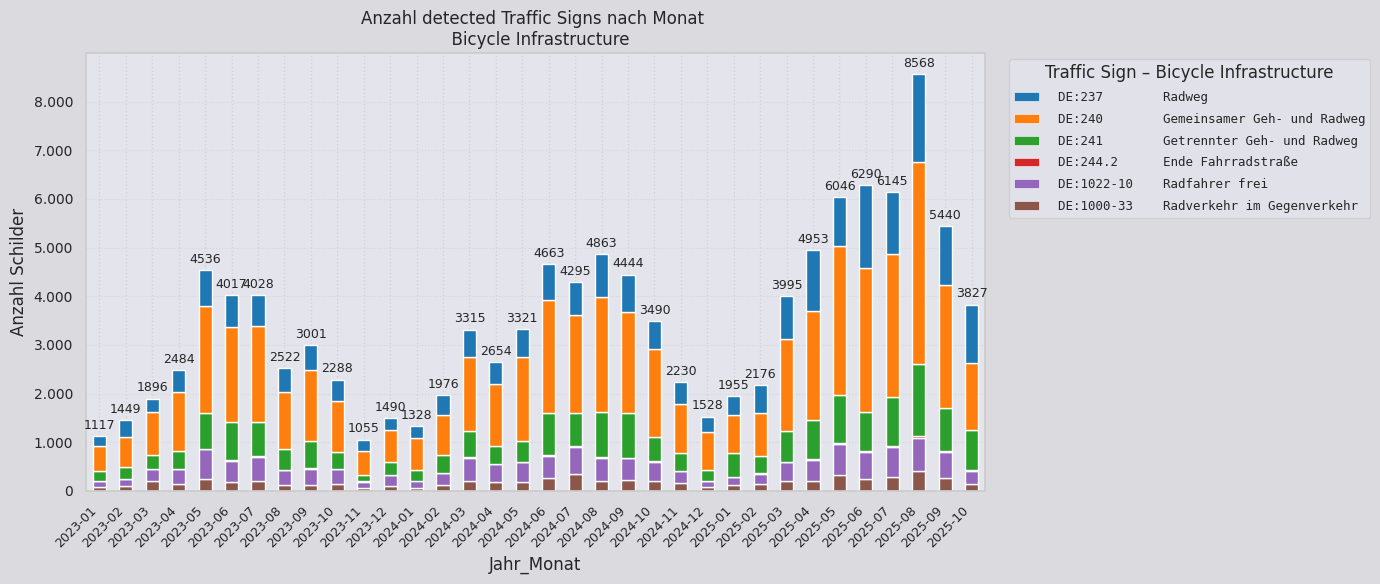

In [150]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import FuncFormatter

df = mapillary_trafficsigns_cw.copy()
df["month"] = pd.to_datetime(df["last_seen_at"]).dt.to_period("M").dt.to_timestamp()

# Pivot
pivot = (df.groupby(["month", "traffic_sign_description"])
           .size()
           .unstack(fill_value=0)
           .sort_index())

# Lückenlose Monatsachse
all_months = pd.date_range(pivot.index.min(), pivot.index.max(), freq="MS")
pivot = pivot.reindex(all_months, fill_value=0)
pivot.index.name = "month"

# === gewünschte Reihenfolge ===
order_top_to_bottom = [
    ("DE:237", "Radweg"),
    ("DE:240", "Gemeinsamer Geh- und Radweg"),
    ("DE:241", "Getrennter Geh- und Radweg"),
    ("DE:244.2", "Ende Fahrradstraße"),
    ("DE:1022-10", "Radfahrer frei"),
    ("DE:1000-33", "Radverkehr im Gegenverkehr"),
]

descs_top_to_bottom = [desc for _, desc in order_top_to_bottom if desc in pivot.columns]
pivot_ordered = pivot[descs_top_to_bottom]

# === Farben: Tab10 starten bei "Radweg" ===
tab10 = plt.get_cmap("tab10")
colors = [tab10(i) for i in range(len(descs_top_to_bottom))]

# Reihenfolge fürs Plotten (bottom → top)
descs_bottom_to_top = descs_top_to_bottom[::-1]
colors_bottom_to_top = colors[::-1]

# === Plot ===
fig, ax = plt.subplots(figsize=(14, 6))
pivot_ordered[descs_bottom_to_top].plot(kind="bar", stacked=True, ax=ax, color=colors_bottom_to_top)

# Legende exakt in gewünschter Reihenfolge
handles_drawn, labels_drawn = ax.get_legend_handles_labels()
handle_by_label = dict(zip(labels_drawn, handles_drawn))

max_code_len = max(len(code) for code, desc in order_top_to_bottom)
legend_labels = [
    f"{code.ljust(max_code_len)}    {desc}".replace(" ", "\u00A0")
    for code, desc in order_top_to_bottom
    if desc in pivot_ordered.columns
]
ax.legend(
    legend_handles, legend_labels,
    title="Traffic Sign – Bicycle Infrastructure",
    bbox_to_anchor=(1.02, 1), loc="upper left",
    prop={"family": "monospace", "size": 9},
    handletextpad=1.5, labelspacing=0.7
)


# Achsen & Layout
ax.set_xticks(range(len(pivot_ordered.index)))
ax.set_xticklabels([d.strftime("%Y-%m") for d in pivot_ordered.index], rotation=45, ha="right")
ax.tick_params(axis="x", labelsize=9)

# keine wissenschaftliche Notation
ax.ticklabel_format(style='plain', axis='y')
# Tausenderpunkt (deutsches Schema)
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{x:,.0f}".replace(",", ".")))

ax.yaxis.set_major_locator(mtick.MaxNLocator(integer=True))
ax.tick_params(axis="y", labelsize=10)


ax.grid(axis="y", linestyle=":", linewidth=0.8, alpha=0.6)

ax.set_xlabel("Jahr_Monat")
ax.set_ylabel("Anzahl Schilder")
ax.set_title("Anzahl detected Traffic Signs nach Monat \n  Bicycle Infrastructure")

# Totals über Balken
totals = pivot_ordered.sum(axis=1).to_numpy()
for i, total in enumerate(totals):
    if total > 0:
        ax.text(i, total + max(totals)*0.01, str(int(total)), ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.savefig("ts_output/signs_by_month.svg", bbox_inches="tight")
plt.show()


### create readme file

In [153]:
from datetime import datetime
import pandas as pd

# === deine DataFrame-Basis ===
# mapillary_trafficsigns_cw = ...

# Zähle die Anzahl pro Beschreibung
counts = mapillary_trafficsigns_cw["traffic_sign_description"].value_counts().to_dict()

# Hole das aktuelle Datum
current_date = datetime.now().strftime("%Y-%m-%d")

# Mapping für Reihenfolge und Metadaten
sign_info = [
    ("DE:237", "regulatory--bicycles-only--g1", "Radweg", "https://trafficsigns.osm-verkehrswende.org/_next/static/media/DE_237.36e48b6d.svg"),
    ("DE:240", "regulatory--shared-path-pedestrians-and-bicycles--g1", "Gemeinsamer Geh- und Radweg", "https://trafficsigns.osm-verkehrswende.org/_next/static/media/DE_240.c2d222a0.svg"),
    ("DE:241", "regulatory--dual-path-pedestrians-and-bicycles--g1`<br>`regulatory--dual-path-bicycles-and-pedestrians--g1", "Getrennter Geh- und Radweg", 
        "https://trafficsigns.osm-verkehrswende.org/_next/static/media/DE_241_30.69c98777.svg", 
        "https://trafficsigns.osm-verkehrswende.org/_next/static/media/DE_241_31.3627eb18.svg"),
    ("DE:244.2", "regulatory--end-of-bicycles-only--g2", "Ende Fahrradstraße", "https://trafficsigns.osm-verkehrswende.org/_next/static/media/DE_244_2.b586a5a6.svg"),
    ("DE:1022-10", "complementary--except-bicycles--g1", "Radfahrer frei", "https://trafficsigns.osm-verkehrswende.org/_next/static/media/DE_1022_10.cda7bd53.svg"),
    ("DE:1000-33", "complementary--bike-route--g1", "Radverkehr im Gegenverkehr", "https://trafficsigns.osm-verkehrswende.org/_next/static/media/DE_1000_33.c18820f3.svg"),
]

# === Markdown-Tabelle bauen ===
table_rows = []
for info in sign_info:
    code, wording, desc, *imgs = info
    count = counts.get(desc, 0)
    # Bild(e) zusammenbauen
    if len(imgs) == 2:
        img_md = f'<img src="{imgs[0]}" width="40"> oder <img src="{imgs[1]}" width="40">'
    else:
        img_md = f'<img src="{imgs[0]}" width="40">'
    row = f"| {code} | `{wording}` | {desc} | {count} | {img_md} |"
    table_rows.append(row)

table = "\n".join([
    "| VZ-Code | Mapillary Wording | Beschreibung | Anzahl | Verkehrszeichen |",
    "|------|-------------------|---------------|---------:|--------|",
    *table_rows
])

# === README-Text ===
readme_content = f"""
# Bicycle Infrastucture Traffic Signs Output
This folder contains the output file for detected traffic signs related to bicycle infrastructure from Mapillary.  
The output has been created on **{current_date}**.

## Applied Filters
- Only detections newer than **2023-01-01**
- Excluded all signs located within **30 m of motorways** (to reduce false positives)

## Signs

{table}

## Statistics Plot
![Anzahl pro Monat](signs_by_month.svg)
"""

# === Datei schreiben ===
with open("ts_output/README_neu.md", "w", encoding="utf-8") as readme_file:
    readme_file.write(readme_content)

print("✅ README_neu.md erfolgreich erstellt!")


✅ README_neu.md erfolgreich erstellt!
